# Load Financial database
## Load stock data from CSMAR

In [30]:
from csmarapi.CsmarService import CsmarService
csmar = CsmarService()

In [31]:
# Load DB credentials from .env and log in to CSMAR
# Prerequisite: pip install python-dotenv and create a .env file with DB_USER and DB_PASS
# Security note: avoid hardcoding secrets in notebooks; use environment variables instead.
import os
from dotenv import load_dotenv

# Load variables from .env into the current environment
load_dotenv()

# Read CSMAR credentials (make sure .env defines DB_USER and DB_PASS)
# You can replace these with your actual credentials
user = os.getenv("DB_USER")
pwd  = os.getenv("DB_PASS")

# Authenticate with the CSMAR service using the credentials
csmar.login(user, pwd)

Sun 31 Aug 2025 16:11:56 CsmarService.py INFO User login succeed


In [32]:
# Download stock data for Pingan Bank
data = csmar.query_df( ['Stkcd','Trddt','Opnprc','Hiprc', 'Loprc', 'Clsprc'], 
                      "Stkcd=000001", 'TRD_Dalyr','2005-01-01','2009-12-31')
print(data)

       Stkcd       Trddt  Opnprc  Hiprc  Loprc  Clsprc
0     000001  2005-01-04    6.59   6.59   6.46    6.52
1     000001  2005-01-05    6.52   6.55   6.35    6.46
2     000001  2005-01-06    6.50   6.59   6.45    6.52
3     000001  2005-01-07    6.58   6.60   6.46    6.51
4     000001  2005-01-10    6.51   6.59   6.37    6.59
...      ...         ...     ...    ...    ...     ...
1132  000001  2009-12-23   22.76  23.06  22.28   22.55
1133  000001  2009-12-24   22.65  23.31  22.46   23.28
1134  000001  2009-12-29   23.40  23.81  23.00   23.59
1135  000001  2009-12-30   23.59  24.53  23.42   24.39
1136  000001  2009-12-31   24.38  24.69  24.09   24.37

[1137 rows x 6 columns]


In [ ]:
# Export data
data.to_csv('pingan_bank_stock_data.csv', index=False)

<Axes: title={'center': 'Pingan Bank Stock Price (2005-2009)'}, xlabel='Trddt'>

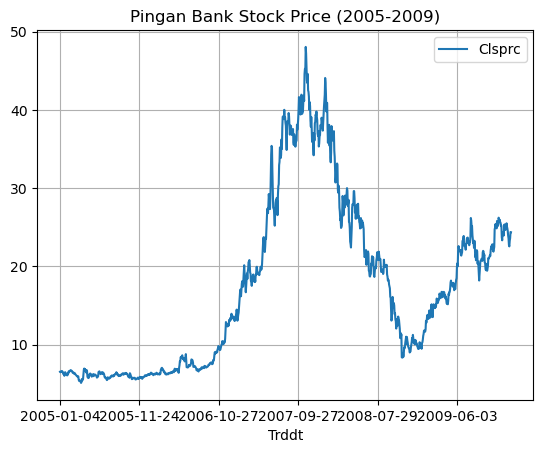

In [33]:
data.plot(x='Trddt', y='Clsprc', title='Pingan Bank Stock Price (2005-2009)', grid=True)

## Load Microsoft stock data from WRDS

In [3]:
# Download monthly MSFT data (2000-2015) from WRDS CRSP and plot close price
# Prerequisite: pip install wrds; you will be prompted for your WRDS credentials
# Tip: set environment variable WRDS_USERNAME to skip the username prompt
import os
import wrds
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt

load_dotenv()

# Optional: read WRDS username from environment (WRDS_USER)
wrds_user = os.getenv("WRDS_USER")

# Connect to WRDS (prompts for credentials if not cached)
conn = wrds.Connection(wrds_username=wrds_user)

Loading library list...
Done
Done


In [25]:
# Use CRSP monthly stock file (msf) and map MSFT ticker to PERMNO via stocknames
sql = """
WITH msft_perm AS (
  SELECT DISTINCT permno
  FROM crsp.stocknames
  WHERE ticker = 'MSFT'
)
SELECT
  msf.date,
  msf.permno,
  ABS(msf.prc) AS prc,   -- CRSP stores prc possibly negative for bid/ask direction
  msf.cfacpr
FROM crsp.msf AS msf
JOIN msft_perm ap ON msf.permno = ap.permno
WHERE msf.date BETWEEN '2000-01-01' AND '2015-12-31'
ORDER BY msf.date;
"""

# Fetch data (parse date)
df = conn.raw_sql(sql, date_cols=["date"]) 
conn.close()  # close connection when done

In [27]:
df.head()

,date,permno,prc,cfacpr
0,2000-01-31,10107,97.875,2.0
1,2000-02-29,10107,89.375,2.0
2,2000-03-31,10107,106.25,2.0
3,2000-04-28,10107,69.75,2.0
4,2000-05-31,10107,62.5625,2.0


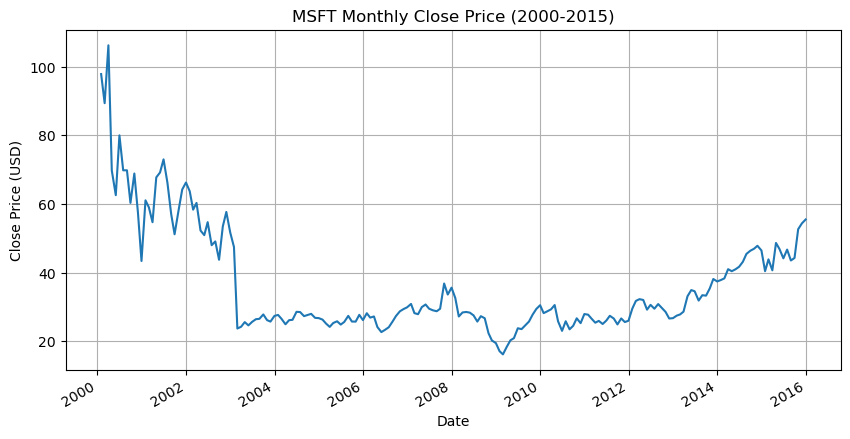

In [28]:
# Plot close (monthly)
df = df.sort_values("date")
ax = df.set_index("date")["prc"].plot(
    figsize=(10, 5),
    title="MSFT Monthly Close Price (2000-2015)",
    grid=True,
)
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
plt.show()

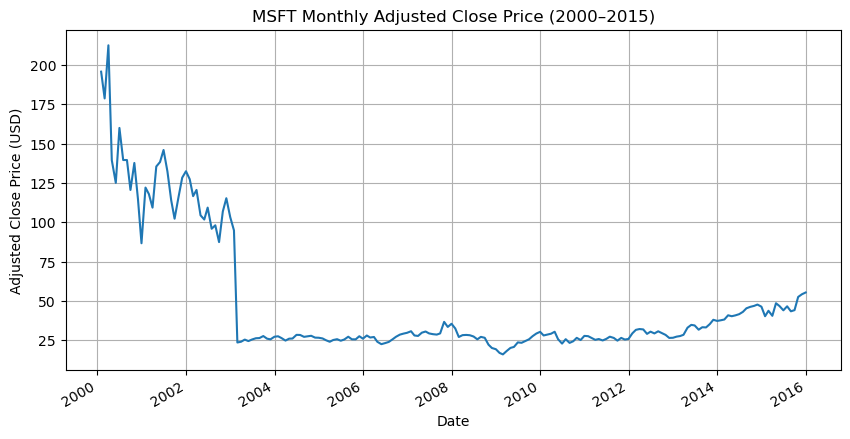

In [29]:
# Optionally compute split-adjusted price (commented out)
df["adj_prc"] = df["prc"] * df["cfacpr"]

# Plot adjusted close (monthly)
df = df.sort_values("date")
ax = df.set_index("date")["adj_prc"].plot(
    figsize=(10, 5),
    title="MSFT Monthly Adjusted Close Price (2000–2015)",
    grid=True,
)
ax.set_xlabel("Date")
ax.set_ylabel("Adjusted Close Price (USD)")
plt.show()

# Descriptive Statistics
Descriptive statistics are the cornerstone of empirical research, providing essential diagnostics to ensure the scientific selection of models and the validity of estimation results. This process safeguards empirical analysis through three key steps:

- **1. Data Quality Assessment and Distribution Identification**

    - By calculating statistics such as mean, variance, skewness, and kurtosis, and using visual tools like boxplots and kernel density plots, researchers can systematically identify data anomalies (e.g., outliers), distribution deviations (e.g., right-skewed housing prices), and structural issues. For example, a skewness coefficient greater than 3 suggests the need for log transformation, while high kurtosis warns of outlier interference in parameter estimation.

- **2. Model Assumption Verification**

    - **Stationarity Testing:** The ADF unit root test, combined with time series plots, helps detect non-stationary characteristics in macroeconomic variables like GDP, preventing spurious regressions (e.g., false correlation between ice cream sales and drowning incidents). This guides the use of differencing or cointegration analysis.

    - **Variance Stability Testing:** Time series scatter plots reveal variance trends, while the White test confirms heteroscedasticity. If housing price variance increases with predictors (e.g., White test p < 0.05), OLS should be replaced with weighted least squares (WLS) or generalized linear models (GLM).

    - **Serial Correlation Diagnosis:** Autocorrelation function (ACF) plots and the Ljung-Box test effectively identify autocorrelation issues in ARIMA models, preserving the validity of parameter estimates.

- **3. Model Selection and Optimization**

    - Descriptive statistics directly inform modeling strategies: right-skewed data may require Box-Cox transformation, heteroscedastic series point to WLS estimation, and non-stationary series necessitate vector error correction models (VECM). These preprocessing steps significantly improve the statistical properties of estimators—making OLS estimates not only unbiased but also efficient, and transforming VAR model parameters from inconsistent to consistent estimates.

## Mean, Variance, Extremes, Quantiles, etc.

Can be quickly obtained using the `describe` method in a pandas DataFrame.

In [3]:
import pandas as pd

sp500_df = pd.read_stata('sp500.dta')
sp500_df.set_index(["caldt"], drop=True, inplace=True)
sp500_df.head()

,vwretd,vwretx,ewretd,ewretx,totval,totcnt,usdval,usdcnt,spindx,sprtrn
caldt,,,,,,,,,,
1981-02-02,-0.019400,-0.020806,-0.017969,-0.018723,860671216.0,500,878958424.0,499,126.91,-0.020378
1981-02-03,0.013638,0.012727,0.010229,0.009953,871625274.0,500,860671216.0,499,128.46,0.012213
1981-02-04,0.001049,0.000640,0.005337,0.004980,872201939.0,500,871625274.0,499,128.59,0.001012
1981-02-05,0.008967,0.008120,0.009656,0.009496,879284525.0,500,872201939.0,499,129.63,0.008088
1981-02-06,0.008564,0.008046,0.006735,0.005945,886151310.0,500,879197837.0,498,130.60,0.007483


In [ ]:
## The three columns represent:
# ewretx: Equal-Weighted Return (excluding dividends)
# vwretx: Value-Weighted Return (excluding dividends)
# sprtrn: S&P 500 Index Return (including dividends)
sp500_ret = sp500_df.loc[:,['ewretx','vwretx','sprtrn']]
des_stat = sp500_ret.describe().T
des_stat

,count,mean,std,min,25%,50%,75%,max
ewretx,10085.0,0.000483,0.011805,-0.184269,-0.004349,0.000707,0.005726,0.120949
vwretx,10085.0,0.000396,0.011281,-0.194659,-0.004435,0.000576,0.005586,0.115133
sprtrn,10085.0,0.000398,0.011340,-0.204669,-0.004476,0.000550,0.005651,0.115800


## Advanced Metrics

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

### Skewness（偏度）
- $\text{Sample Skewness } \hat{sk}=  T^{-1}{\textstyle \sum_{t=1}^{T}} \frac{(X_t - \hat{\mu})^3}{\hat{\sigma}^3}$  
- Describes the asymmetry of the data distribution
- Financial data characteristics:
    - Right-skewed (positive skewness): extremely high returns but usually low returns.
    - Left-skewed (negative skewness): risk of extreme losses. Most stock returns are negatively skewed, as we will see with the SP500 below.
- Remedies: logarithmic transformation, use of quantile regression models
- Threshold: absolute value > 0.5 is considered significant skewness

In [6]:
des_stat.loc['ewretx','skew'] = stats.skew(sp500_ret.ewretx)
des_stat.loc['vwretx','skew'] = stats.skew(sp500_ret.vwretx)
des_stat.loc['sprtrn','skew'] = stats.skew(sp500_ret.sprtrn)
des_stat

,count,mean,std,min,25%,50%,75%,max,skew
ewretx,10085.0,0.000483,0.011805,-0.184269,-0.004349,0.000707,0.005726,0.120949,-0.577535
vwretx,10085.0,0.000396,0.011281,-0.194659,-0.004435,0.000576,0.005586,0.115133,-0.683769
sprtrn,10085.0,0.000398,0.011340,-0.204669,-0.004476,0.000550,0.005651,0.115800,-0.748029


### Kurtosis（峰度）
- Formula: $\text{Kurtosis } \hat{K} = T^{-1}{\textstyle \sum_{t=1}^{T}} \frac{(X_t - \hat{\mu})^4}{\hat{\sigma}^4}$
- Detects the peakedness / fat-tail characteristics of a distribution
- Financial data features:
    - High kurtosis (>3): higher probability of extreme events than under normal distribution (e.g., Black Swan events)
    - Low kurtosis (<3): smoother fluctuations (e.g., government bond yields)
- Coping strategies: assume t-distribution, apply Extreme Value Theory (EVT)

In [7]:
des_stat.loc['ewretx','kurtosis'] = stats.kurtosis(sp500_ret.ewretx)
des_stat.loc['vwretx','kurtosis'] = stats.kurtosis(sp500_ret.vwretx)
des_stat.loc['sprtrn','kurtosis'] = stats.kurtosis(sp500_ret.sprtrn)
des_stat

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
ewretx,10085.0,0.000483,0.011805,-0.184269,-0.004349,0.000707,0.005726,0.120949,-0.577535,18.343688
vwretx,10085.0,0.000396,0.011281,-0.194659,-0.004435,0.000576,0.005586,0.115133,-0.683769,18.809293
sprtrn,10085.0,0.000398,0.011340,-0.204669,-0.004476,0.000550,0.005651,0.115800,-0.748029,20.606189


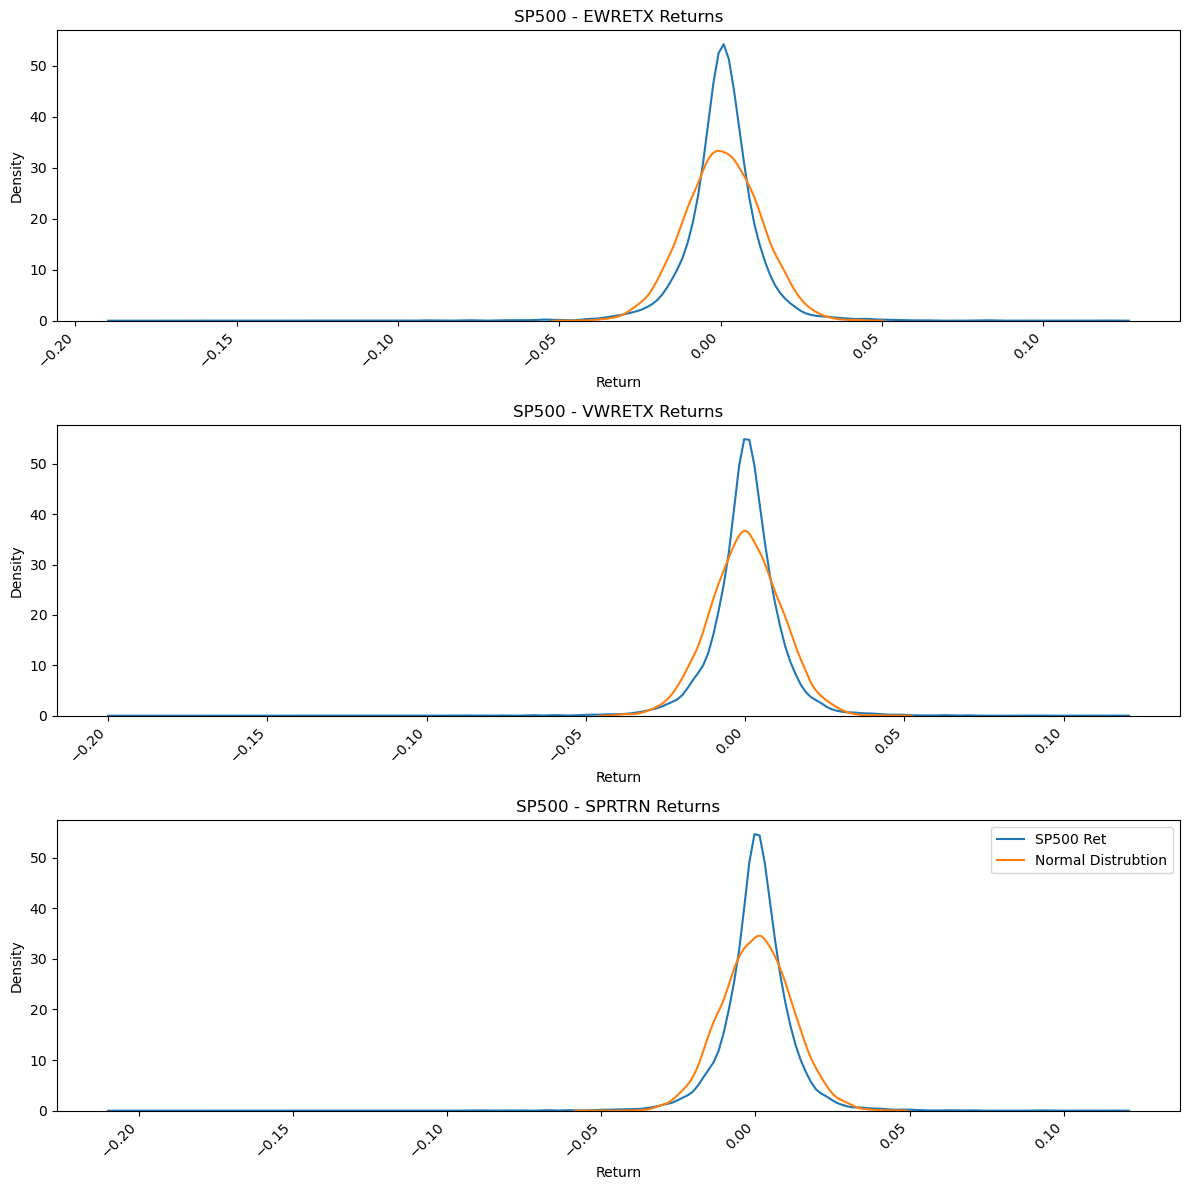

In [ ]:
## visualization
# Create a subplot with 3 rows and 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))
# Iterate over the three columns of the DataFrame
for i, column in enumerate(['ewretx', 'vwretx', 'sprtrn']):
    # Generate corresponding normal data (same mean and standard deviation)
    normal_data = np.random.normal(loc=des_stat.loc[column,'mean'], scale=des_stat.loc[column,'std'], size=len(sp500_ret.sprtrn))
    
    # Plot histogram and KDE (Kernel Density Estimation) curve
    sns.kdeplot(sp500_ret[column], ax=axes[i], label="SP500 Ret")
    sns.kdeplot(normal_data, ax=axes[i], label="Normal Distribution")
    
    # Set subplot title
    axes[i].set_title(f'SP500 - {column.upper()} Returns')
    
    # Set x-axis label
    axes[i].set_xlabel('Return')
    
    # Set y-axis label
    axes[i].set_ylabel('Density')
    
    # Rotate x-axis labels to avoid overlap
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Adjust spacing between subplots
    plt.tight_layout()

# Set legend
plt.legend(labels=['SP500 Ret','Normal Distribution'])

# Show plot
plt.show()